In [23]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# torch.manual_seed(1234)
# if device =='cuda':
#     torch.cuda.manual_seed_all(1234)

print(device)

cpu


#### Разделение на обучающую, тестовую и валидационую выборки

In [24]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotations.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df.sample(10))


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:  
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df,train_path,i)
for i in range(1000,1800):
    load_train(df,train_path,i)

for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
    
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index                    full_path   img_class
1030   1031  dataset\polar bear\0031.jpg  polar bear
871     872  dataset\brown bear\0872.jpg  brown bear
225     226  dataset\brown bear\0226.jpg  brown bear
1882   1883  dataset\polar bear\0883.jpg  polar bear
1544   1545  dataset\polar bear\0545.jpg  polar bear
1781   1782  dataset\polar bear\0782.jpg  polar bear
351     352  dataset\brown bear\0352.jpg  brown bear
299     300  dataset\brown bear\0300.jpg  brown bear
1617   1618  dataset\polar bear\0618.jpg  polar bear
1993   1994  dataset\polar bear\0994.jpg  polar bear


#### Проверка

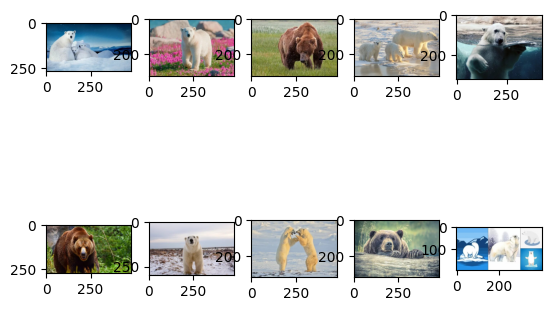

In [25]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

Увелечение изображений


In [26]:
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_transforms = common_transforms

val_transforms = common_transforms

test_transforms = common_transforms

Загрузка наборов

In [27]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'polar bear':
            label=1
        elif label == 'brown bear':
            label=0
            
        return img_transformed,label

In [28]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

#### Проверка

In [29]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.3922, 0.3922, 0.3765,  ..., 0.2431, 0.2353, 0.2353],
         [0.3922, 0.3922, 0.3765,  ..., 0.2431, 0.2353, 0.2353],
         [0.4039, 0.4039, 0.3882,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.6275, 0.6353, 0.6353],
         [0.4196, 0.4196, 0.4235,  ..., 0.6431, 0.6471, 0.6471],
         [0.4196, 0.4196, 0.4235,  ..., 0.6471, 0.6471, 0.6471]],

        [[0.4980, 0.4980, 0.4824,  ..., 0.4588, 0.4510, 0.4510],
         [0.4980, 0.4980, 0.4824,  ..., 0.4588, 0.4510, 0.4510],
         [0.5098, 0.5098, 0.4941,  ..., 0.4706, 0.4627, 0.4627],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.7725, 0.7765, 0.7765],
         [0.4196, 0.4196, 0.4235,  ..., 0.7882, 0.7922, 0.7922],
         [0.4196, 0.4196, 0.4235,  ..., 0.7922, 0.7922, 0.7922]],

        [[0.6157, 0.6157, 0.6039,  ..., 0.6000, 0.5922, 0.5922],
         [0.6157, 0.6157, 0.6039,  ..., 0.6000, 0.5922, 0.5922],
         [0.6275, 0.6275, 0.6196,  ..., 0.6118, 0.6039, 0

#### Обучение

In [30]:
lr = 0.001 
batch_size = 10 
epochs = 10 
def create_loaders():
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
    return (train_loader, test_loader, val_loader)

train_loader, test_loader, val_loader = create_loaders()
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))

1440 144
160 16


Построение модели

In [31]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [33]:
print(len(train_data), len(train_loader))

1440 144


In [34]:
print(len(val_data), len(val_loader))

160 16


In [35]:
train_data[0][0].shape

torch.Size([3, 224, 224])

Цикл обучения

In [36]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
def train(model, epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()


  epoch_val_accuracy_list = []
  epoch_val_loss_list = []
  epoch_accuracy_list = []
  epoch_loss_list = []

  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
      epoch_accuracy_list.append(epoch_accuracy)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_accuracy=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)


              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_accuracy += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

      epoch_val_accuracy_list.append(epoch_val_accuracy)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_accuracy_list,epoch_val_loss_list, epoch_accuracy_list, epoch_loss_list)

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)




Epoch : 1, train accuracy : 0.8395835757255554, train loss : 0.3785340487957001
Epoch : 1, val_accuracy : 0.875, val_loss : 0.3201732337474823
Epoch : 2, train accuracy : 0.8993058800697327, train loss : 0.273466020822525
Epoch : 2, val_accuracy : 0.90625, val_loss : 0.2404019981622696
Epoch : 3, train accuracy : 0.8993055820465088, train loss : 0.26442474126815796
Epoch : 3, val_accuracy : 0.856249988079071, val_loss : 0.3199165165424347
Epoch : 4, train accuracy : 0.8875003457069397, train loss : 0.28157299757003784
Epoch : 4, val_accuracy : 0.9124999642372131, val_loss : 0.2478712797164917
Epoch : 5, train accuracy : 0.9069445729255676, train loss : 0.23807452619075775
Epoch : 5, val_accuracy : 0.9124999046325684, val_loss : 0.22589194774627686
Epoch : 6, train accuracy : 0.9090279340744019, train loss : 0.23631271719932556
Epoch : 6, val_accuracy : 0.9249999523162842, val_loss : 0.23062796890735626
Epoch : 7, train accuracy : 0.90625, train loss : 0.23475804924964905
Epoch : 7, val

#### Графики прогресса обучения

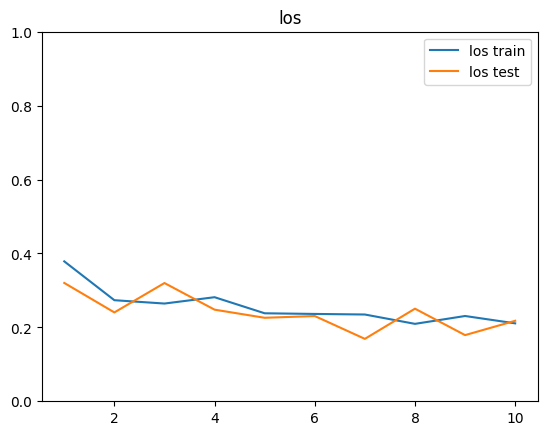

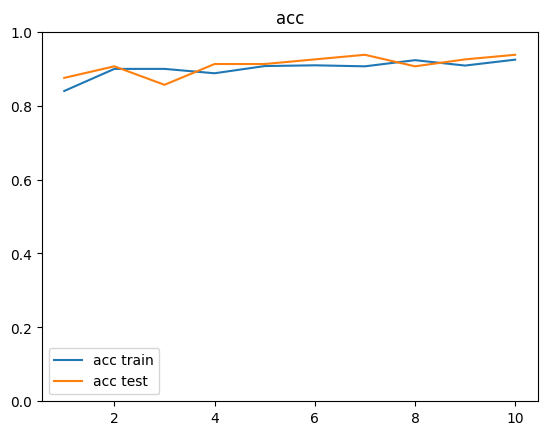

In [37]:
def show_plot(lis, list_val, text):
  x = list(range(1, len(lis)+ 1))
  plt.plot(x, lis, label = text+" train")
  plt.plot(x, list_val, label = text+" test")
  plt.title(text)
  plt.ylim(0,1.0)
  plt.legend()
  plt.show()

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")


Epoch : 1, train accuracy : 0.9319442510604858, train loss : 0.18592889606952667
Epoch : 1, val_accuracy : 0.8999999165534973, val_loss : 0.2077842503786087
Epoch : 2, train accuracy : 0.9270835518836975, train loss : 0.197190523147583
Epoch : 2, val_accuracy : 0.9374999403953552, val_loss : 0.2022932767868042
Epoch : 3, train accuracy : 0.9263888597488403, train loss : 0.1807747483253479
Epoch : 3, val_accuracy : 0.9437500238418579, val_loss : 0.1664765328168869
Epoch : 4, train accuracy : 0.9340271949768066, train loss : 0.18092046678066254
Epoch : 4, val_accuracy : 0.9062499403953552, val_loss : 0.2830023467540741
Epoch : 5, train accuracy : 0.9416666626930237, train loss : 0.16343028843402863
Epoch : 5, val_accuracy : 0.9437500238418579, val_loss : 0.14243119955062866
Epoch : 6, train accuracy : 0.9354164004325867, train loss : 0.18149618804454803
Epoch : 6, val_accuracy : 0.9312499761581421, val_loss : 0.19915562868118286
Epoch : 7, train accuracy : 0.9333335161209106, train loss 

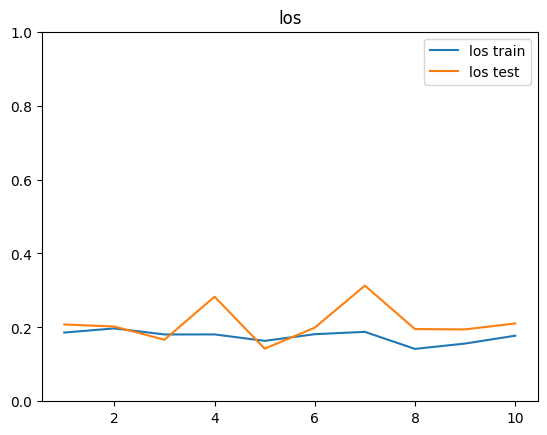

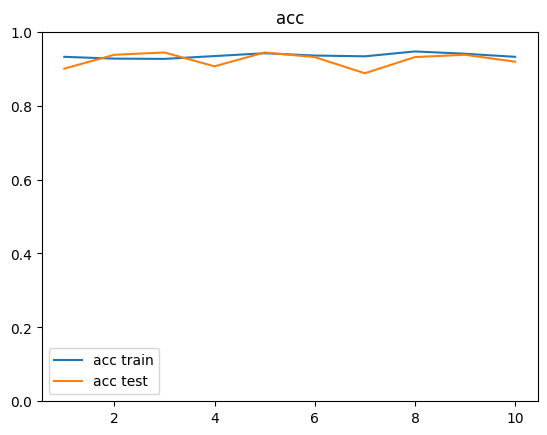

In [38]:
lr = 0.0005 # learning_rate
batch_size = 10 # we will use mini-batch method

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.847222626209259, train loss : 0.3651072680950165
Epoch : 1, val_accuracy : 0.893750011920929, val_loss : 0.29357799887657166
Epoch : 2, train accuracy : 0.8888891935348511, train loss : 0.28849533200263977
Epoch : 2, val_accuracy : 0.875, val_loss : 0.3078959286212921
Epoch : 3, train accuracy : 0.8972225785255432, train loss : 0.2586667239665985
Epoch : 3, val_accuracy : 0.925000011920929, val_loss : 0.22943806648254395
Epoch : 4, train accuracy : 0.909722626209259, train loss : 0.24600625038146973
Epoch : 4, val_accuracy : 0.8999998569488525, val_loss : 0.27617788314819336
Epoch : 5, train accuracy : 0.9145835041999817, train loss : 0.22741296887397766
Epoch : 5, val_accuracy : 0.875, val_loss : 0.27563703060150146
Epoch : 6, train accuracy : 0.9215277433395386, train loss : 0.22193780541419983
Epoch : 6, val_accuracy : 0.9062499403953552, val_loss : 0.22091728448867798
Epoch : 7, train accuracy : 0.9104166030883789, train loss : 0.22612015902996063
Epoc

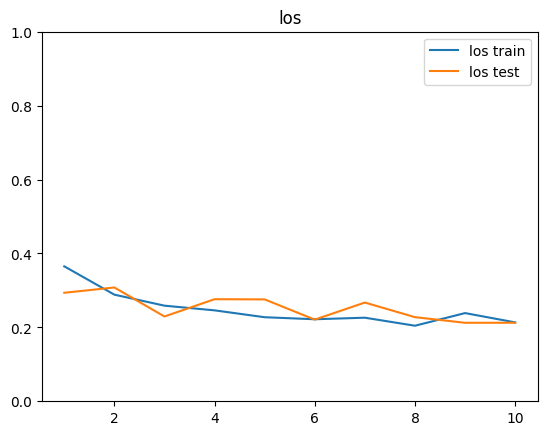

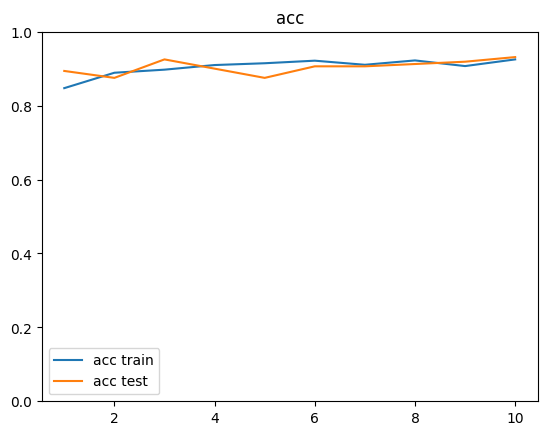

In [39]:
lr = 0.0007 # learning_rate
batch_size = 10 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.8868052959442139, train loss : 0.2792181968688965
Epoch : 1, val_accuracy : 0.8687499165534973, val_loss : 0.28131842613220215
Epoch : 2, train accuracy : 0.9027776122093201, train loss : 0.2527022361755371
Epoch : 2, val_accuracy : 0.9249999523162842, val_loss : 0.2038983404636383
Epoch : 3, train accuracy : 0.9208331108093262, train loss : 0.22019898891448975
Epoch : 3, val_accuracy : 0.90625, val_loss : 0.22583797574043274
Epoch : 4, train accuracy : 0.9291664361953735, train loss : 0.20359288156032562
Epoch : 4, val_accuracy : 0.918749988079071, val_loss : 0.22994135320186615
Epoch : 5, train accuracy : 0.9111109972000122, train loss : 0.24429747462272644
Epoch : 5, val_accuracy : 0.9312499761581421, val_loss : 0.2673165202140808
Epoch : 6, train accuracy : 0.9201387166976929, train loss : 0.2114764004945755
Epoch : 6, val_accuracy : 0.90625, val_loss : 0.24380934238433838
Epoch : 7, train accuracy : 0.9229166507720947, train loss : 0.20951776206493378

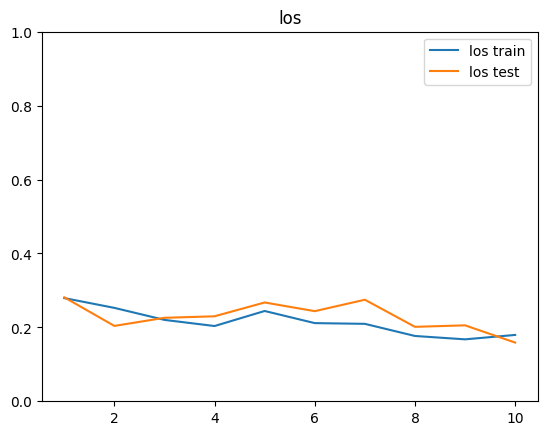

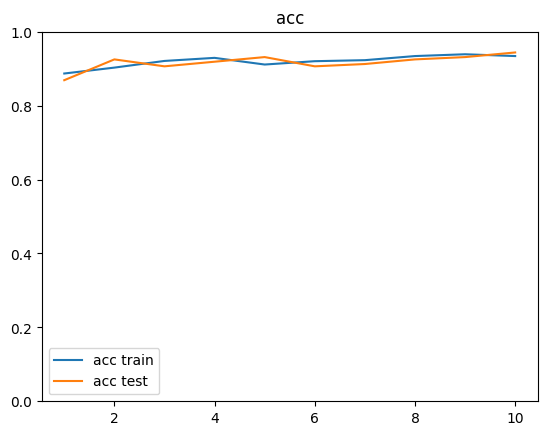

In [40]:
lr = 0.001 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.8395832180976868, train loss : 0.3761356770992279
Epoch : 1, val_accuracy : 0.856249988079071, val_loss : 0.35490065813064575
Epoch : 2, train accuracy : 0.904166579246521, train loss : 0.25632598996162415
Epoch : 2, val_accuracy : 0.875, val_loss : 0.2938319444656372
Epoch : 3, train accuracy : 0.9166665077209473, train loss : 0.2191295474767685
Epoch : 3, val_accuracy : 0.9437499642372131, val_loss : 0.1901858150959015
Epoch : 4, train accuracy : 0.9180554747581482, train loss : 0.22273410856723785
Epoch : 4, val_accuracy : 0.8687500357627869, val_loss : 0.2622722089290619
Epoch : 5, train accuracy : 0.9305554628372192, train loss : 0.19936314225196838
Epoch : 5, val_accuracy : 0.9437500238418579, val_loss : 0.18585705757141113
Epoch : 6, train accuracy : 0.9243053793907166, train loss : 0.20108868181705475
Epoch : 6, val_accuracy : 0.9000000357627869, val_loss : 0.23936928808689117
Epoch : 7, train accuracy : 0.9347220659255981, train loss : 0.178178101

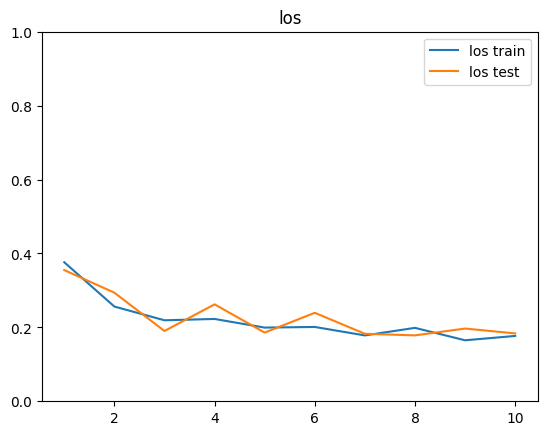

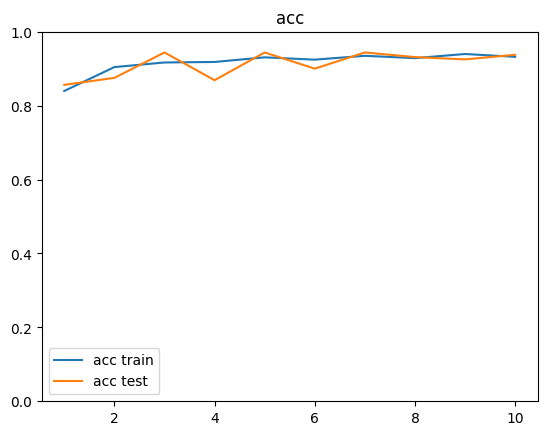

In [41]:
lr = 0.0005 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.874305248260498, train loss : 0.3214957118034363
Epoch : 1, val_accuracy : 0.875, val_loss : 0.29386085271835327
Epoch : 2, train accuracy : 0.9062498211860657, train loss : 0.2421295940876007
Epoch : 2, val_accuracy : 0.887499988079071, val_loss : 0.27989211678504944
Epoch : 3, train accuracy : 0.9194443821907043, train loss : 0.22529873251914978
Epoch : 3, val_accuracy : 0.875, val_loss : 0.3313905596733093
Epoch : 4, train accuracy : 0.9111109972000122, train loss : 0.23402173817157745
Epoch : 4, val_accuracy : 0.887499988079071, val_loss : 0.23770339787006378
Epoch : 5, train accuracy : 0.9284721612930298, train loss : 0.19695886969566345
Epoch : 5, val_accuracy : 0.9249999523162842, val_loss : 0.22550494968891144
Epoch : 6, train accuracy : 0.9277774691581726, train loss : 0.19602930545806885
Epoch : 6, val_accuracy : 0.8999999761581421, val_loss : 0.24212831258773804
Epoch : 7, train accuracy : 0.9277777671813965, train loss : 0.19498789310455322
Epo

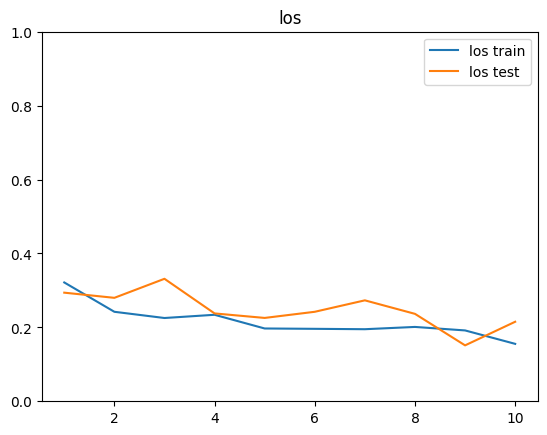

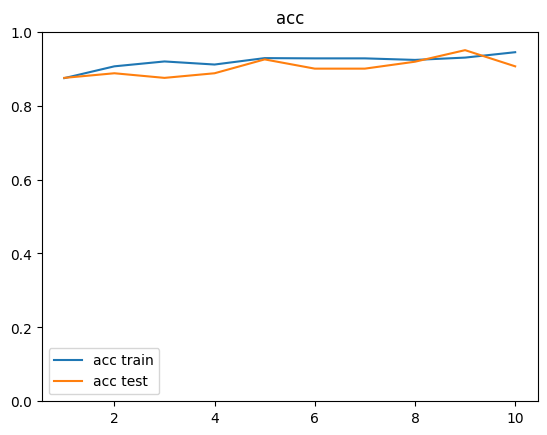

In [42]:
lr = 0.0007 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.8682757616043091, train loss : 0.36271482706069946
Epoch : 1, val_accuracy : 0.9249999523162842, val_loss : 0.26435744762420654
Epoch : 2, train accuracy : 0.9105172753334045, train loss : 0.2420753389596939
Epoch : 2, val_accuracy : 0.8999999761581421, val_loss : 0.29999083280563354
Epoch : 3, train accuracy : 0.9210345149040222, train loss : 0.20694731175899506
Epoch : 3, val_accuracy : 0.9049999713897705, val_loss : 0.19515171647071838
Epoch : 4, train accuracy : 0.925517201423645, train loss : 0.18553517758846283
Epoch : 4, val_accuracy : 0.9249999523162842, val_loss : 0.1754179298877716
Epoch : 5, train accuracy : 0.9310345649719238, train loss : 0.17614291608333588
Epoch : 5, val_accuracy : 0.875, val_loss : 0.3170774579048157
Epoch : 6, train accuracy : 0.9298274517059326, train loss : 0.19620563089847565
Epoch : 6, val_accuracy : 0.9449999928474426, val_loss : 0.16486400365829468
Epoch : 7, train accuracy : 0.9441379308700562, train loss : 0.150189

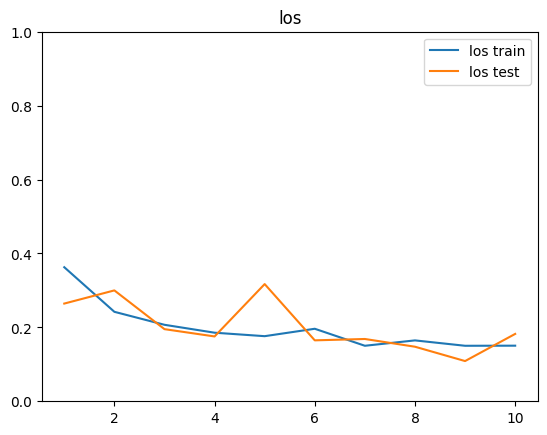

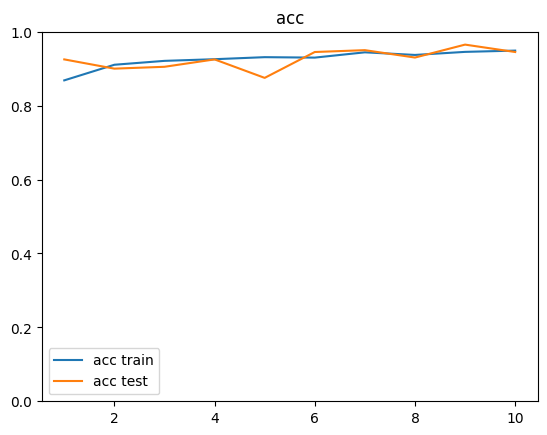

In [43]:
lr = 0.001 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.852758526802063, train loss : 0.38983771204948425
Epoch : 1, val_accuracy : 0.8899999856948853, val_loss : 0.25903087854385376
Epoch : 2, train accuracy : 0.9034481644630432, train loss : 0.2637489140033722
Epoch : 2, val_accuracy : 0.9049999713897705, val_loss : 0.2557125985622406
Epoch : 3, train accuracy : 0.9115517735481262, train loss : 0.23234690725803375
Epoch : 3, val_accuracy : 0.875, val_loss : 0.22596858441829681
Epoch : 4, train accuracy : 0.912758469581604, train loss : 0.24416203796863556
Epoch : 4, val_accuracy : 0.9099999666213989, val_loss : 0.1949062943458557
Epoch : 5, train accuracy : 0.9215517640113831, train loss : 0.20419622957706451
Epoch : 5, val_accuracy : 0.8799999952316284, val_loss : 0.26315099000930786
Epoch : 6, train accuracy : 0.9160345196723938, train loss : 0.2146398425102234
Epoch : 6, val_accuracy : 0.9049999713897705, val_loss : 0.21614685654640198
Epoch : 7, train accuracy : 0.9184483885765076, train loss : 0.20739798

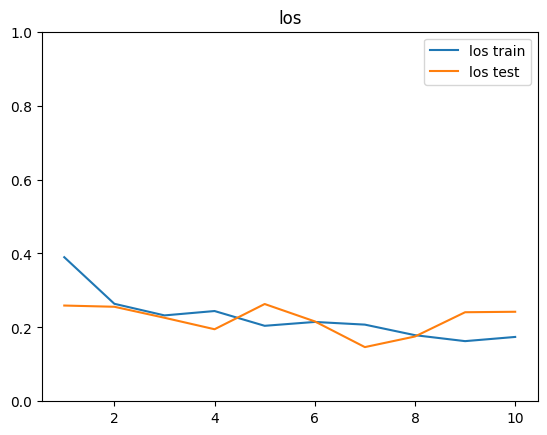

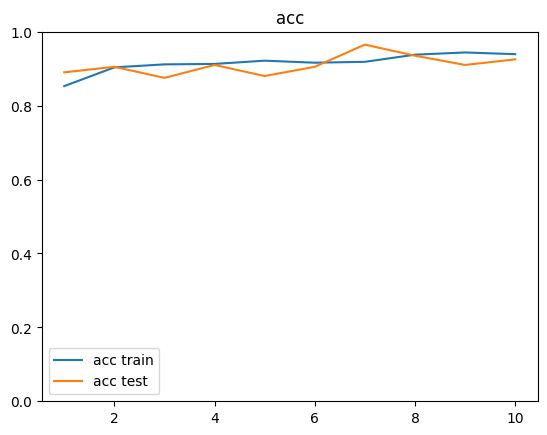

In [44]:
lr = 0.0005 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.8587930202484131, train loss : 0.3677235245704651
Epoch : 1, val_accuracy : 0.934999942779541, val_loss : 0.2223747968673706
Epoch : 2, train accuracy : 0.9032759070396423, train loss : 0.24234770238399506
Epoch : 2, val_accuracy : 0.8749999403953552, val_loss : 0.2922714352607727
Epoch : 3, train accuracy : 0.8970690965652466, train loss : 0.26363226771354675
Epoch : 3, val_accuracy : 0.9299999475479126, val_loss : 0.21049299836158752
Epoch : 4, train accuracy : 0.92258620262146, train loss : 0.19923654198646545
Epoch : 4, val_accuracy : 0.9300000071525574, val_loss : 0.20565766096115112
Epoch : 5, train accuracy : 0.92241370677948, train loss : 0.2049519121646881
Epoch : 5, val_accuracy : 0.9399999976158142, val_loss : 0.19087940454483032
Epoch : 6, train accuracy : 0.9346551895141602, train loss : 0.17759950459003448
Epoch : 6, val_accuracy : 0.9200000166893005, val_loss : 0.20941992104053497
Epoch : 7, train accuracy : 0.9239655137062073, train loss : 

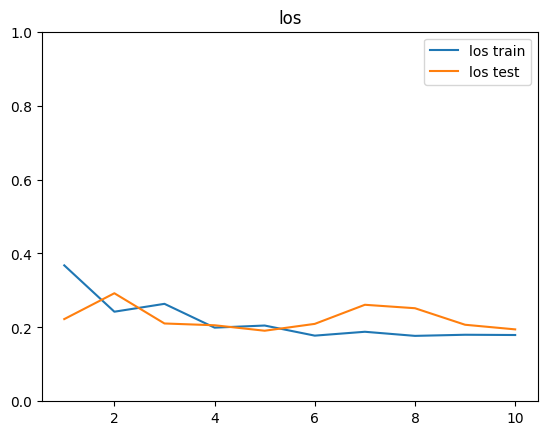

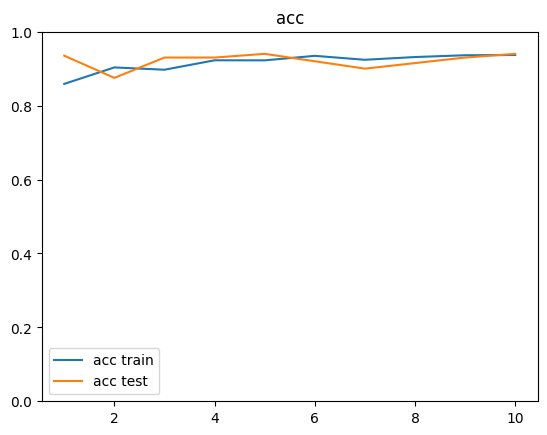

In [45]:
lr = 0.0007 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

In [46]:
polar_bear_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        polar_bear_probs += list(zip(labels, preds_list))

polar_bear_probs.sort(key = lambda x : int(x[0]))
polar_bear_probs

polar_bear_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],polar_bear_probs))
prob = list(map(lambda x: x[1],polar_bear_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,800,0.144201
1,801,0.448143
2,802,0.007612
3,803,0.091330
4,804,0.011119
...,...,...
195,1895,0.985720
196,1896,0.964642
197,1897,0.979263
198,1898,0.987039


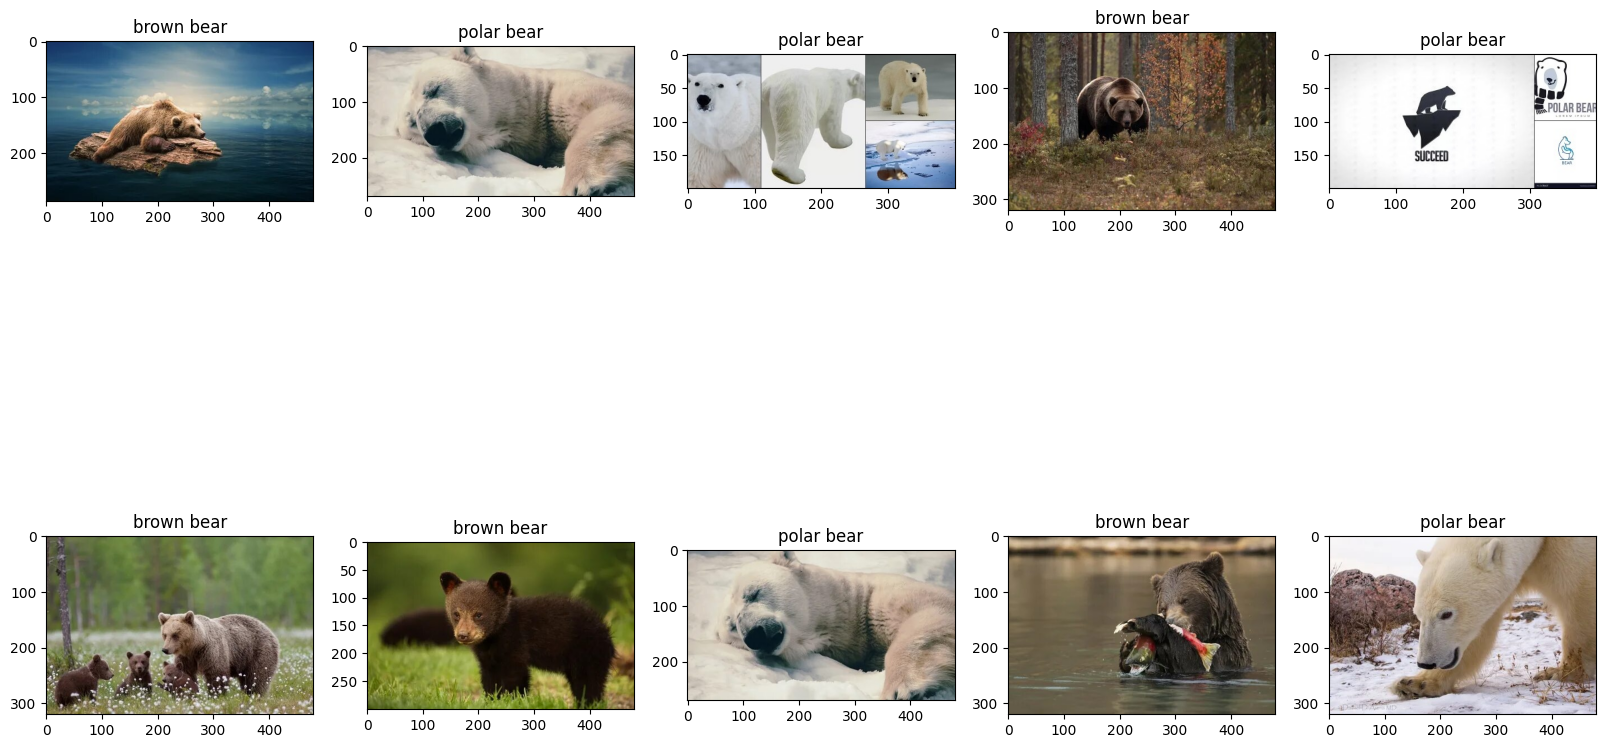

In [47]:
import random

id_list = []
class_ = {0: 'brown bear', 1: 'polar bear'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

#### Работа с тестовыми данными

In [50]:
torch.save(model.state_dict(), os.path.join("D:\Code", "weight.pt"))
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("D:\Code", "weight.pt")))

<All keys matched successfully>

'brown bear'

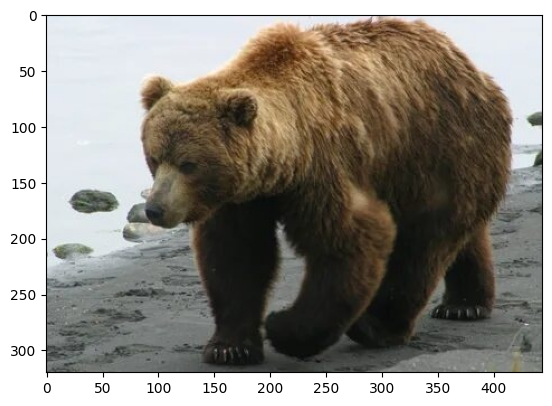

In [55]:
list_files = os.listdir(val_path)
file = list_files[random.randint(0,len(list_files)-1)]


img_path = os.path.join(val_path, file)

img = Image.open(img_path)
img_transformed = test_transforms(img).unsqueeze(dim=0)

output = mymodel(img_transformed)

img = Image.open(img_path)
plt.imshow(img)

preds_list = "brown bear" if output.argmax(dim=1) == 0 else "polar bear"

preds_list

In [52]:
l = []

train_loader, test_loader, val_loader = create_loaders()

for data, label in val_loader:
    output = mymodel(data)
    l.append(output.argmax(dim=1) == label)
l

[tensor([ True,  True,  True,  True,  True,  True, False, False,  True,  True,
          True, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]),
 tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False,  True,  True,  True,  True,  True, False, False,  True,
          True, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True, False,  True,  True,  True,  True,  True]),
 tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True,

In [53]:
sum = 0
count = 0
for i in l:
    sum += torch.sum(i.float())
    count += len(i)

sum / count 

tensor(0.9250)